# Homework 3

*Jinyi Zhou | u1424752 | June 7*

## Part 1 - Data Acquisition

Check out the robots.txt file for HN to make sure you're allowed to scrape it for stories.

*The robots.txt file shows the information below:*
```
User-Agent: *
Disallow: /x?
Disallow: /r?
Disallow: /vote?
Disallow: /reply?
Disallow: /submitted?
Disallow: /submitlink?
Disallow: /threads?
Crawl-delay: 30
```

Grab the first 5 pages of stories from hackernews. For each story, grab the following data:

- Rank (the number of the story on hacker news)
- Length of the title
- Age, in hours (note, some stories are days or minutes old. You should be able to handle this)
- Points (note, some stories don't have scores! Give them 0 points)
- Number of comments (again, some stories have no comments. Mark them 0)
- A lot of HTML on HN has handy class attributes to help make this task a bit easier. Once you have all your data, create a dataframe to store it, and save a CSV file so you don't have to hit the server repeatedly to reload the data.

Most of the table entries are nicely, uniformly formatted, but a few might be missing fields. I'd suggest testing with the common case and fixing edge cases as they come up.

In [55]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import urllib.request

In [56]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import re
import time

url= "https://news.ycombinator.com/?p="

ranks = []
titleLengths = []
agesInHour = []
points = []
numOfComments = []

for i in range(5):
    url1= url + str(i+1)
    with urllib.request.urlopen (url) as response:
        html = response.read().decode("utf-8")
    with open ("story" + str(i+1) + ".html", "w") as new_file:
        new_file.write(html)
    soup = BeautifulSoup(html, 'html.parser')

    # rank
    for post in soup.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.','')
        ranks.append(int(rank))

    # length of title
    for title in soup.find_all(class_="titleline"):
        titleLengths.append(len(title.text))

    # age in hours
    for age in soup.find_all(class_="age"):
        ageString = str(age.text)
        ageString = ageString.removesuffix(" hours ago")
        ageString = ageString.removesuffix(" hour ago")
        if " day ago" in ageString:
            agesInHour.append(24)
        elif " days ago" in ageString:
            ageString = ageString.replace(" days ago", "")
            ageInteger = int(ageString)
            agesInHour.append(24 * ageInteger)
        elif " minute ago" in ageString:
            agesInHour.append(0)
        elif " minutes ago" in ageString:
            agesInHour.append(0)
        else:
            agesInHour.append(int(ageString))

    # points and comments
    for subtext in soup.find_all(class_="subtext" ):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            point = int(re.search(r'\d+', str(score.text)).group())

        for atag in subtext.find_all("a"):
            if atag.text.endswith("comments"):
                aString = str(atag.text)
                comments = int(re.search(r'\d+', aString).group())
        numOfComments.append(int(comments))
        points.append(int(point))
    time.sleep(5) # suggested by Dave, otherwise won't work

# create data frame
dataframe = pd.DataFrame({"rank": ranks, "title_length": titleLengths, "age_in_hours": agesInHour, "points": points, "comment_count": numOfComments})
print(dataframe)

# save csv file
dataframe.to_csv('stories.csv', index=False)



     rank  title_length  age_in_hours  points  comment_count
0       1            59             1      80             25
1       2            38             7     470            185
2       3            80             1      42             13
3       4            78             2     131             58
4       5            50             1      27              8
..    ...           ...           ...     ...            ...
145    26            38             7      76             51
146    27            53             7      43             21
147    28            74            10     398            217
148    29            29             2       6              0
149    30            77             7     431            391

[150 rows x 5 columns]


## Part 2 - Regression

We're interested in how to get a high-ranking story on Hackernews. Explore several possible least squares regressions to predict a story's rank based on the other variables (and combinations thereof). Include at least 3 different regressions. Compare/contrast them. Which is the most useful.  What are the R^2 scores, p-values for coefficients, and values of the coefficients - and what do these tell us?  Plot at least one of your regressions.

In [57]:
result = smf.ols('rank ~ title_length', data=dataframe).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.512
Date:                Fri, 16 Jun 2023   Prob (F-statistic):             0.0353
Time:                        20:33:25   Log-Likelihood:                -534.32
No. Observations:                 150   AIC:                             1073.
Df Residuals:                     148   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.2425      2.340      8.651   

In [58]:
result = smf.ols('rank ~ age_in_hours', data=dataframe).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     25.39
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           1.35e-06
Time:                        20:33:25   Log-Likelihood:                -524.70
No. Observations:                 150   AIC:                             1053.
Df Residuals:                     148   BIC:                             1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.1635      1.247      8.153   

In [59]:
result = smf.ols('rank ~ points', data=dataframe).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9260
Date:                Fri, 16 Jun 2023   Prob (F-statistic):              0.337
Time:                        20:33:25   Log-Likelihood:                -536.10
No. Observations:                 150   AIC:                             1076.
Df Residuals:                     148   BIC:                             1082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.1464      0.977     16.529      0.0

In [60]:
result = smf.ols('rank ~ comment_count', data=dataframe).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     9.800
Date:                Fri, 16 Jun 2023   Prob (F-statistic):            0.00210
Time:                        20:33:25   Log-Likelihood:                -531.76
No. Observations:                 150   AIC:                             1068.
Df Residuals:                     148   BIC:                             1074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.6270      0.913     14.933

In [61]:
result = smf.ols('comment_count ~ points', data=dataframe).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          comment_count   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     106.1
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           4.24e-19
Time:                        20:33:25   Log-Likelihood:                -855.87
No. Observations:                 150   AIC:                             1716.
Df Residuals:                     148   BIC:                             1722.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.4336      8.235      2.967      0.0

In [62]:
results = smf.ols('rank ~ title_length + age_in_hours + points + comment_count', data=dataframe).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     30.77
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           1.53e-18
Time:                        20:33:25   Log-Likelihood:                -490.47
No. Observations:                 150   AIC:                             990.9
Df Residuals:                     145   BIC:                             1006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.7368      2.062      8.116

[Text(0.5, 1.0, 'Rank vs. Points')]

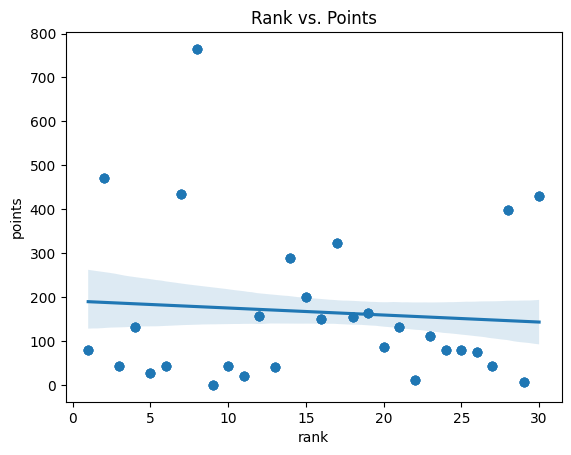

In [63]:
sns.regplot(x="rank", y="points", data=dataframe).set(title="Rank vs. Points")

[Text(0.5, 1.0, 'Rank vs. Age in Hours')]

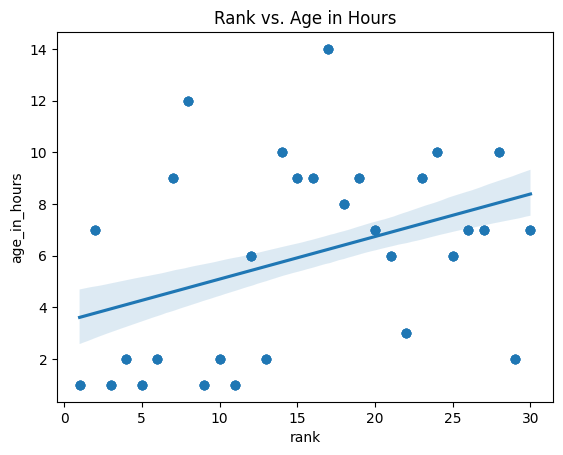

In [64]:
sns.regplot(x="rank", y="age_in_hours", data=dataframe).set(title="Rank vs. Age in Hours")

[Text(0.5, 1.0, 'Rank vs. Age in Hours')]

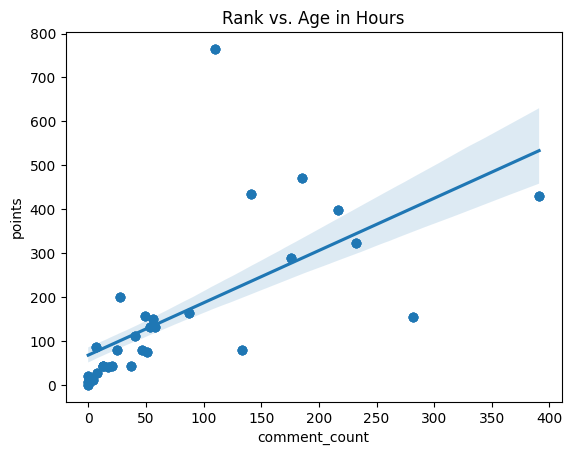

In [65]:
sns.regplot(x="comment_count", y="points", data=dataframe).set(title="Rank vs. Age in Hours")

From the above results, strong linear relationship exists between the rank and the age in hours with a R-square value of 0.146. For the number of comments and points, the R-square value is even 0.418.

## Part 3 - Classification

As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page. Use logistic regression to attempt to classify whether or not an article will be on the front page, given the other **(non-rank)** variables. Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for not), for example.

In [94]:
import matplotlib.pyplot as plt
dataframe

,rank,title_length,age_in_hours,points,comment_count,in_front_page,Score2
0,1,59,1,80,25,1,10.934749
1,2,38,7,470,185,1,8.985377
2,3,80,1,42,13,1,5.674997
3,4,78,2,131,58,1,10.721002
4,5,50,1,27,8,1,3.598778
...,...,...,...,...,...,...,...
145,26,38,7,76,51,1,1.436894
146,27,53,7,43,21,1,0.804661
147,28,74,10,398,217,1,4.531732
148,29,29,2,6,0,1,0.412346


In [95]:
dataframe['in_front_page'] = [1 if x <= 30 else 0 for x in dataframe['rank']] # transf
dataframe.head()

,rank,title_length,age_in_hours,points,comment_count,in_front_page,Score2
0,1,59,1,80,25,1,10.934749
1,2,38,7,470,185,1,8.985377
2,3,80,1,42,13,1,5.674997
3,4,78,2,131,58,1,10.721002
4,5,50,1,27,8,1,3.598778


In [96]:
dataframe.tail()

,rank,title_length,age_in_hours,points,comment_count,in_front_page,Score2
145,26,38,7,76,51,1,1.436894
146,27,53,7,43,21,1,0.804661
147,28,74,10,398,217,1,4.531732
148,29,29,2,6,0,1,0.412346
149,30,77,7,431,391,1,8.238193


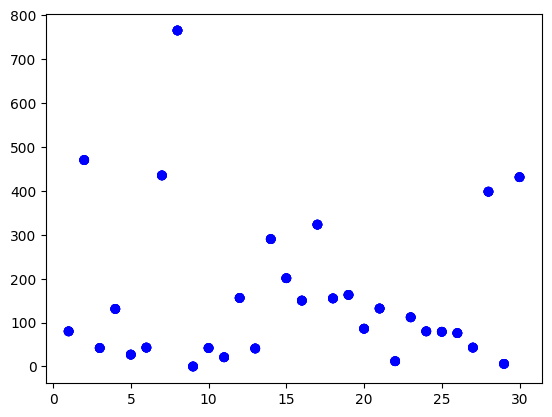

In [97]:
import numpy as np
rank_point_plt = plt.scatter(x=dataframe['rank'], y=dataframe['points'], c=dataframe['in_front_page'].map({0:'red', 1: 'blue'}))
logistic = lambda x: 1 / ( 1 + np.exp(-x) )

Score2 = []
for p,t in zip(dataframe['points'],dataframe['age_in_hours']):
    Score2.append((p-1)/((t+2)**1.8))
dataframe['Score2'] = Score2

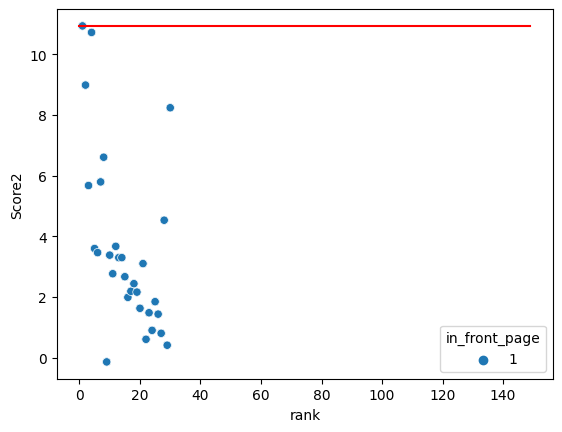

In [98]:
sns.scatterplot(y='Score2',x='rank',hue='in_front_page',data=dataframe)
xs = np.linspace(dataframe['Score2'][30], dataframe['Score2'][30], 150)
plt.plot(xs, color="red")

         Current function value: 0.000003
         Iterations: 35


/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python

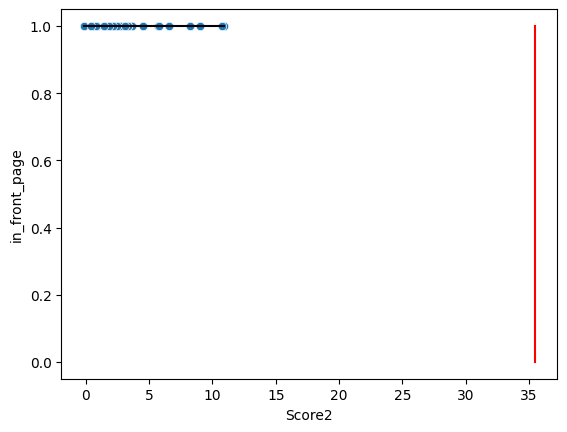

In [108]:
sns.scatterplot(x='Score2', y='in_front_page',data=dataframe)
log_model = sm.logit(formula="in_front_page ~ Score2", data=dataframe).fit()
logistic = lambda x: 1 / ( 1 + np.exp(-x) )

x = np.linspace(dataframe['Score2'].min(), dataframe['Score2'].max(), 1000)
par = dict(log_model.params)
plt.plot(x, logistic(par['Intercept'] + par['Score2'] * x), color='Black')

prob_top_30 = 0.50
estimated_score_toPass = np.log(0.5) - par['Intercept'] / par['Score2']

plt.plot( [estimated_score_toPass, estimated_score_toPass], [0, 1], 'r' )

In [109]:
logReg = smf.logit('in_front_page ~ age_in_hours + points', dataframe).fit()
logReg.summary()

         Current function value: 0.000000
         Iterations: 35


/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          in_front_page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Fri, 16 Jun 2023   Pseudo R-squ.:                     inf
Time:                        21:23:25   Log-Likelihood:            -1.9584e-11
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       26.0855    1.7e+06   1.54e-05      1.000   -3.33e+06    3.33e+06
age_in_hours     0.3040   1.66e+06   1.83e-07      1.000   -3.26e+06    3.26e+06
points           0.3077   2.59e+05   1.19e-06      1.000   -5.07e+05    5.07e+05
================================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

   rank  title_length  age_in_hours  points  comment_count  in_front_page   
0     1            59             1      80             25              1  \
1     2            38             7     470            185              1   
2     3            80             1      42             13              1   
3     4            78             2     131             58              1   
4     5            50             1      27              8              1   

      Score2  predictions  
0  10.934749    51.004258  
1   8.985377   172.824940  
2   5.674997    39.312247  
3  10.721002    67.000122  
4   3.598778    34.696980  


/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

(1.0, 151.0)

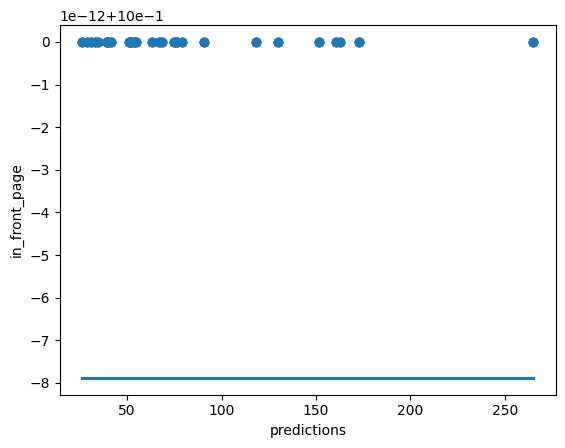

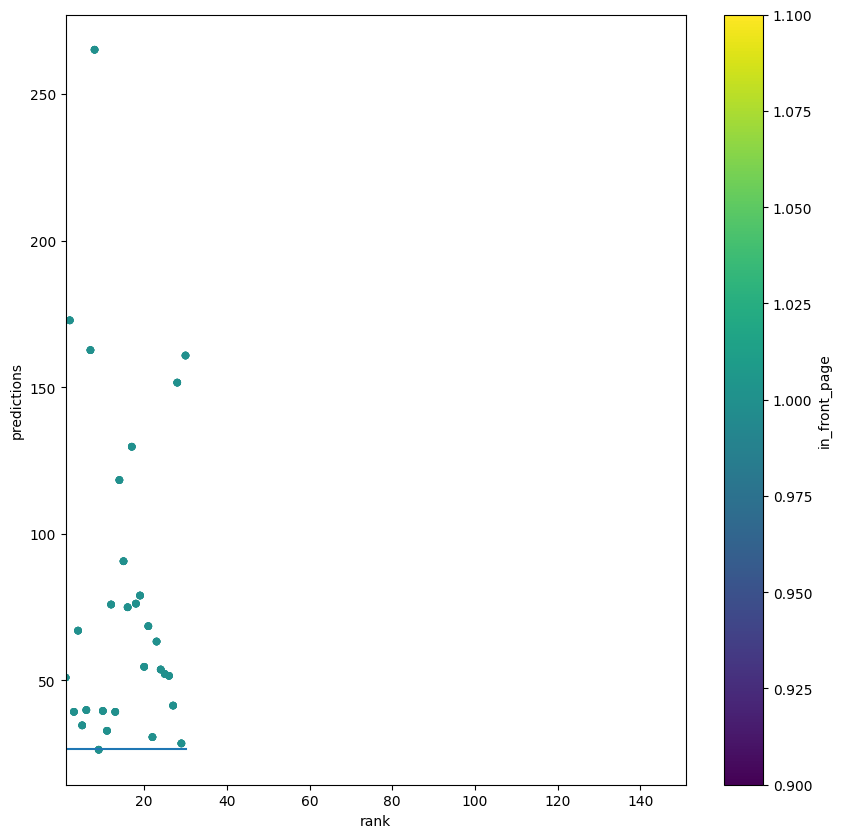

In [110]:
p = logReg.params
predictions = []
for index, row in dataframe.iterrows() :
    predictions.append(p.Intercept + p.points * row.points + p.age_in_hours * row.age_in_hours)

dataframe["predictions"] = predictions
sns.regplot(y='in_front_page', x='predictions', data=dataframe, logistic=True)

ax = dataframe.plot(x='rank', y='predictions', kind='scatter', c='in_front_page', colormap='viridis', figsize=[10,10])
print(dataframe.head())

x=dataframe['rank']

ax.plot(x, [p.Intercept + p.points + p.age_in_hours for x in range(1,151)])
ax.set_xlim([1, 151])

My model didn't do a great job at predicting whether or not the story is in the front page. It's probably because that the algorithm for determining it is much complicated than we can predict.